# E-MOSAIC

引用自[E. R. Q. Fernandes, A. C. P. L. F. de Carvalho and X. Yao, "Ensemble of Classifiers Based on Multiobjective Genetic Sampling for Imbalanced Data," in IEEE Transactions on Knowledge and Data Engineering, vol. 32, no. 6, pp. 1104-1115, 1 June 2020, doi: 10.1109/TKDE.2019.2898861.]


## 数据集的预处理 

In [1]:
import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from utils.dataset_utils import get_classes_indexes_counts
import scipy.io as sio  # 从.mat文件中读取数据集
from ucimlrepo import fetch_ucirepo

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 随机种子
random_seed = 42
print("#########################加载数据集#########################")
# 数据集
# Nursery(0.1)、Satellite(0.001)、Contraceptive(0.1)
datasetname = 'Satellite.mat'
mat_data = sio.loadmat('../../data/dataset/' + datasetname)

dataset_x = mat_data['X']
dataset_y = mat_data['Y'][:, 0]  # mat_data['Y']得到的形状为[n,1]，通过[:,0]，得到形状[n,]
# 显示数据集分布
print("特征数据:", dataset_x.shape)
print("label:", dataset_y.shape)
# 统计每个类别的个数
classes, counts = get_classes_indexes_counts(dataset_y)  #np.argmax(y_onehot, axis=1)找最大值的索引，将0-1序列转化为0,1,2,3......的整数标签
print("每种类别的分布：", counts)
print("#########################划分数据集#########################")
x_train, x_test, y_train, y_test = train_test_split(dataset_x, dataset_y, test_size=0.3, random_state=random_seed)
# 显示数据集分布
print("特征数据:", x_train.shape)
print("label:", y_train.shape)
# 统计每个类别的个数 
classes_train, counts_train = get_classes_indexes_counts(y_train)
# 计算每个类的权重
weights_train = (1 / counts_train.astype(float)) / np.sum(1 / counts_train.astype(float))
print("训练集每种类别的分布：", counts_train)
print("训练集每种类别的权重：", weights_train)
classes_test, counts_test = get_classes_indexes_counts(y_test)
print("测试集每种类别的分布：", counts_test)
print("#########################平衡数据集#########################")
# 确定每个类别的分布
num_instances = int(counts_train.min() * 1.0)  # 向下取整
num_instances_train = len(y_train)  # 取训练集的数量

print("最小数量:", num_instances)
# 在每个类别中随机的选择该数量的实例的索引
balanced_classes = np.array([])
for indexes in classes_train:
    random_selecte_indices = np.random.choice(indexes, size=num_instances, replace=False)
    balanced_classes = np.hstack((balanced_classes, random_selecte_indices))
balanced_classes = np.sort(balanced_classes).astype(int)
# 得到平衡的数据集
balanced_dataset_x = []
balanced_dataset_y = []
for index in balanced_classes:
    balanced_dataset_x.append(x_train[index])
    balanced_dataset_y.append(y_train[index])
balanced_dataset_x = np.array(balanced_dataset_x)
balanced_dataset_y = np.array(balanced_dataset_y).astype(int)
# 显示数据集分布
print("平衡的数据集的特征数据:", balanced_dataset_x.shape)
print("label:", balanced_dataset_y.shape)
# 统计每个类别的分布
classes_balanced_dataset, counts_balanced_dataset = get_classes_indexes_counts(balanced_dataset_y)
print("平衡的数据集中每种类别的分布：", counts_balanced_dataset)

#########################加载数据集#########################
特征数据: (6435, 36)
label: (6435,)
每种类别的分布： [1533  703 1358  626  707 1508]
#########################划分数据集#########################
特征数据: (4504, 36)
label: (4504,)
训练集每种类别的分布： [1083  517  942  425  488 1049]
训练集每种类别的权重： [0.09955827 0.20855244 0.11446031 0.25369791 0.22094593 0.10278514]
测试集每种类别的分布： [450 186 416 201 219 459]
#########################平衡数据集#########################
最小数量: 425
平衡的数据集的特征数据: (2550, 36)
label: (2550,)
平衡的数据集中每种类别的分布： [425 425 425 425 425 425]


## 评价函数
（Acc1、Acc2、Acc3）
Acc1、Acc2是实例选择选了多少，S就是多少；而Acc3是划分完数据集之后，每个类的数量作为si

In [2]:
from scipy.stats import gmean
from sklearn.metrics import precision_score, roc_auc_score, accuracy_score
from scipy.stats import mode


##########################适应度函数（Acc1,Acc2,Acc3）#################################
def fitness_function(individual):
    # 使用训练数据进行预测
    y_sub, ind_pred = individual.y_sub_and_pred[0], individual.y_sub_and_pred[1]  # 获取个体的实例选择标签和预测标签
    ######################计算混淆矩阵#########################
    cm = confusion_matrix(y_sub, ind_pred)
    tp_per_class = cm.diagonal()  # 对角线元素表示每个类预测正确的个数，对角线求和，即所有预测正确的实例个数之和，计算Acc1
    s_per_class = cm.sum(axis=1)
    Acc1 = np.sum(tp_per_class) / np.sum(s_per_class)  # Acc1
    Acc2 = np.mean(tp_per_class.astype(float) / s_per_class.astype(float))  # Acc2
    Acc3 = np.mean((tp_per_class.astype(float) / s_per_class.astype(float)) * weights_train)  # Acc3
    return round(Acc1, 4), round(Acc2, 4), round(Acc3, 4)

# 集成分类器的投票
def vote_ensembles(ensembles,show_result=False):
    y_pred_labels_ensembles = []
    y_pred_prob_labels_ensembles = []
    for ensemble in ensembles:
        ind_pred = ensemble.predict(x_test)  # 计算accuracy、PPV
        ind_proba = ensemble.predict_proba(x_test)
        y_pred_labels_ensembles.append(ind_pred)
        y_pred_prob_labels_ensembles.append(ind_proba)
    # 按列投票，取每列中出现次数最多的类别作为最终分类结果
    final_pred_result = mode(y_pred_labels_ensembles, axis=0, keepdims=False).mode.flatten()
    # 堆叠为三维数组
    stacked_predictions_prob = np.stack(y_pred_prob_labels_ensembles, axis=0)
    # 对第一个维度 (num_classifiers) 求平均
    ensemble_predictions_prob = np.mean(stacked_predictions_prob, axis=0)
    # 计算 ROC AUC（ovo+macro）
    auc_ovo_macro = roc_auc_score(y_test, ensemble_predictions_prob, multi_class="ovo", average="macro")
    cm = confusion_matrix(y_test, final_pred_result)
    # 计算每类召回率（每类正确预测个数 / 该类总数）
    recall_per_class = cm.diagonal() / cm.sum(axis=1)

    # 计算G-Mean
    geometric_mean = gmean(recall_per_class)
    # 计算准确率
    accuracy = accuracy_score(y_test, final_pred_result)
    if show_result:
        print(f'Accuracy: {accuracy:.2f}')
        # 打印分类报告
        print("Classification Report:")
        print(classification_report(y_test, final_pred_result))
        # 打印混淆矩阵
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, final_pred_result))
    return geometric_mean, auc_ovo_macro, np.array(["{:.6f}".format(x) for x in recall_per_class]).tolist()  # 保留六位小数

## NDGA-II

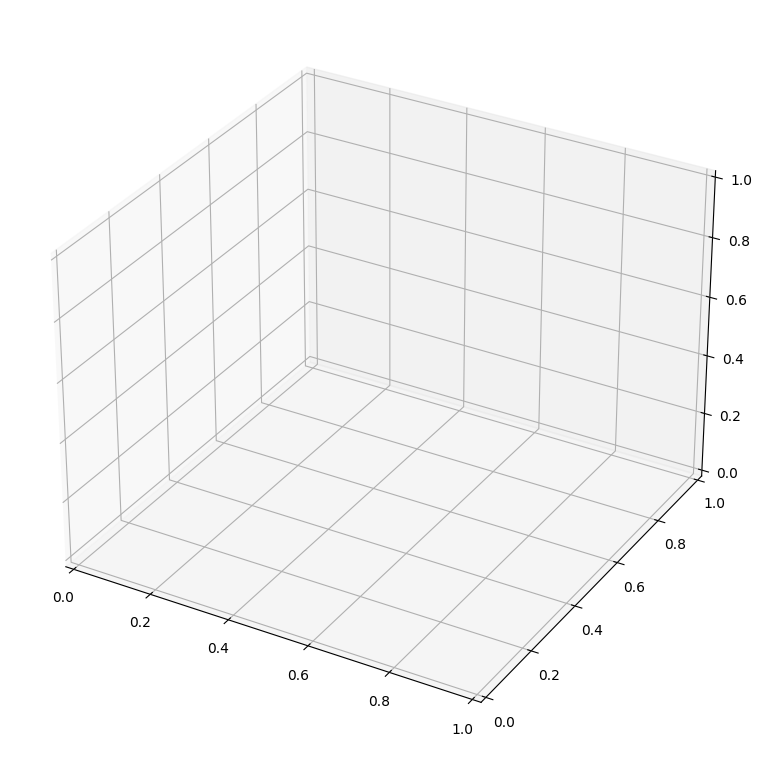

In [3]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from instance_selection.multi_objective.genetic_operator import selNSGA2, mutate_binary_inversion, selTournamentDCD, \
    exponential_distribution, find_duplicates, remove_duplicates
import warnings

warnings.filterwarnings("ignore")  # 忽略警告
from sklearn.neural_network import MLPClassifier

import array
import random
import matplotlib.pyplot as plt
from deap import base
from deap import creator
from deap import tools

from matplotlib.animation import FuncAnimation, PillowWriter

# 最大化评价目标
creator.create("FitnessMaxAndMax", base.Fitness, weights=(1.0, 1.0, 1.0))
'''
fitness:适应度：Gmean和mAUC
pfc：每个分类器的成对故障信用，用于评估分类器集合的多样性
'''
creator.create("Individual", array.array, typecode='i', fitness=creator.FitnessMaxAndMax, pfc=None, mlp=None,
               y_sub_and_pred=None)
toolbox = base.Toolbox()

NDIM = num_instances_train
# 设置参数
lambda_ = 1.3  # 指数分布的参数λ（lambda）在下面的函数中，该值越大越偏向于1
threshold = 1.0  # 阈值（阈值决定了生成0或1）

# 二进制编码
toolbox.register("attr_binary", exponential_distribution, lambda_, threshold)  # 0-1编码
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_binary, n=num_instances)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 适应度函数
toolbox.register("evaluate", fitness_function)

# 单点交叉
toolbox.register("mate", tools.cxOnePoint)

# 二进制突变
toolbox.register("mutate", mutate_binary_inversion)

# NSGA-II选择（非支配排序后）
toolbox.register("select", selNSGA2, x_test=x_test, y_test=y_test)
# toolbox.register("select", tools.selNSGA2)

# 找到种群中重复个体的索引对
toolbox.register("find_duplicates", find_duplicates)

# 去重
toolbox.register("remove_duplicates", remove_duplicates)


# 运行NSGA-II算法并绘图
def plot_pareto(pareto_fronts, ax):
    colors = plt.cm.viridis(np.linspace(0, 1, len(pareto_fronts)))
    for i, front in enumerate(pareto_fronts):
        front_points = np.array([ind.fitness.values for ind in front])
        ax.scatter(front_points[:, 0], front_points[:, 1], front_points[:, 2], label=f"Front {i}", color=colors[i])


# Step 2: 动画绘图函数
fig = plt.figure(figsize=(12.8, 9.6))
ax = fig.add_subplot(111, projection='3d')

# 动画中的数据
pareto_fronts_history = []


def update(frame):
    ax.clear()

    colors = plt.cm.viridis(np.linspace(0, 1, len(pareto_fronts_history[frame])))

    for i, front in enumerate(pareto_fronts_history[frame]):
        front_points = np.array([ind.fitness.values for ind in front])
        ax.scatter(front_points[:, 0], front_points[:, 1], front_points[:, 2], color=colors[i], label=f"Front {i}")
    ax.set_title(f"Generation {frame}")
    ax.set_xlabel("Acc 1")
    ax.set_ylabel("Acc 2")
    ax.set_zlabel("Acc 3")
    # ticks = np.linspace(0, 1, 10)
    # ax.set_xticks(ticks)
    # ax.set_yticks(ticks)
    # ax.set_zticks(ticks)
    ax.legend()

## 种群的迭代

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from utils.dataset_utils import get_subset


def main(seed=None):
    random.seed(seed)

    NGEN = 30  # 迭代次数
    POPSIZE = 40  # 种群数量
    CXPB = 1.0  # 交叉因子/交叉率
    MR = 0.25  # 突变因子/突变率
    # MLP
    learning_rate = 0.001
    hidden_size = 20
    max_iter = 1000
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 配置五折交叉验证

    ####################################迭代过程的记录#############################
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "fronts", "fronts_0_size", "Acc1", "Acc2", "Acc3", "recall_per_class","Gmean", "mAUC"
    ####################################种群的初始化###########################
    pop = toolbox.population(n=POPSIZE)
    ####################################计算初始种群的适应度###########################
    stop_sign = 0
    ensembles = []  # 当前每个个体对应的mlp模型
    # 对于每个个体都训练得到一个mlp模型
    for i in range(len(pop)):
        mlp = MLPClassifier(hidden_layer_sizes=(hidden_size,), max_iter=max_iter, random_state=random_seed,
                            learning_rate_init=learning_rate)
        x_sub, y_sub = get_subset(pop[i], x_train, y_train)
        # 使用 cross_val_predict 进行交叉验证并获取预测
        y_pred = cross_val_predict(mlp, x_sub, y_sub, cv=cv)
        # 用实例选择的子集训练模型
        mlp = MLPClassifier(hidden_layer_sizes=(hidden_size,), max_iter=max_iter, random_state=random_seed,
                                learning_rate_init=learning_rate)
        mlp.fit(x_sub, y_sub)
        pop[i].mlp = mlp
        pop[i].y_sub_and_pred = (y_sub, y_pred)
    # 由mlp模型得到个体的适应度
    for i in range(len(pop)):
        pop[i].fitness.values = toolbox.evaluate(pop[i])
    #################################计算PFC并进行非支配排序#########################################
    # 计算PFC并进行非支配排序 PFC代替拥挤距离
    pop, pareto_fronts = toolbox.select(pop, len(pop))
    ####################################种群的迭代#################################################
    for gen in range(1, NGEN + 1):
        # 选择
        offspring = selTournamentDCD(pop, POPSIZE)
        offspring = [toolbox.clone(ind) for ind in offspring]
        # 交叉
        for i in range(0, len(offspring) - 1, 2):
            if random.random() <= CXPB:
                offspring[i], offspring[i + 1] = toolbox.mate(offspring[i], offspring[i + 1])
            # 突变
            offspring[i] = toolbox.mutate(offspring[i], MR)[0]
            offspring[i + 1] = toolbox.mutate(offspring[i + 1], MR)[0]
            del offspring[i].fitness.values, offspring[i + 1].fitness.values
        # 计算新的种群适应度 
        ensembles.clear()
        for i in range(len(offspring)):
            mlp = MLPClassifier(hidden_layer_sizes=(hidden_size,), max_iter=max_iter, random_state=random_seed,
                                learning_rate_init=learning_rate)
            x_sub, y_sub = get_subset(offspring[i], x_train, y_train)
            # 使用 cross_val_predict 进行交叉验证并获取预测
            y_pred = cross_val_predict(mlp, x_sub, y_sub, cv=cv)
            # 用实例选择的子集训练模型
            mlp = MLPClassifier(hidden_layer_sizes=(hidden_size,), max_iter=max_iter, random_state=random_seed,
                                learning_rate_init=learning_rate)
            mlp.fit(x_sub, y_sub)
            offspring[i].mlp = mlp
            offspring[i].y_sub_and_pred = (y_sub, y_pred)
        for i in range(len(offspring)):
            offspring[i].fitness.values = toolbox.evaluate(offspring[i])
        # 种群的合并
        pop = pop + offspring
        ###############################################得到pareto_fronts############################################
        pop, pareto_fronts = toolbox.select(pop, POPSIZE)
        #pop, pareto_fronts = toolbox.select(pop, POPSIZE)
        record = stats.compile(pop)
        # 保存第一个等级里的mlp模型进行集成
        for ind in pareto_fronts[0]:
            ensembles.append(ind.mlp)
        Acc1_list = []
        Acc2_list = []
        Acc3_list = []
        for ind in pareto_fronts[0]:
            Acc1_list.append(ind.fitness.values[0])
            Acc2_list.append(ind.fitness.values[1])
            Acc3_list.append(ind.fitness.values[2])
        # 求Acc1_list、Acc2_list、Acc3_list的平均值
        Acc1_mean = sum(Acc1_list) / len(Acc1_list)
        Acc2_mean = sum(Acc2_list) / len(Acc2_list)
        Acc3_mean = sum(Acc3_list) / len(Acc3_list)
        g_mean, m_auc, recall_per_class = vote_ensembles(ensembles)
        logbook.record(gen=gen, evals=len(pop), fronts=len(pareto_fronts), fronts_0_size=len(pareto_fronts[0]),
                       Acc1=Acc1_mean, Acc2=Acc2_mean, Acc3=Acc3_mean, recall_per_class=recall_per_class, Gmean=g_mean,
                       mAUC=m_auc,
                       **record)
        print(logbook.stream)
        # 清除并绘制当前一代的 Pareto-front
        pareto_fronts_history.append(pareto_fronts)

    # 使用 FuncAnimation 生成动画
    savepath = "C:/Users/sc_zh/Desktop/"
    writer = PillowWriter(fps=1)  # 设置帧率
    anim = FuncAnimation(fig, update, frames=len(pareto_fronts_history), interval=200)
    anim.save(savepath + datasetname + "_pareto_front.gif", writer=writer)
    plt.show()
    return pop, stats, ensembles


if __name__ == "__main__":
    pop, stats, ensembles = main()
    print("##############################集成分类器的预测结果：################################")
    g_mean, m_auc, recall_per_class = vote_ensembles(ensembles,show_result=True)
    print(f"最终的集成分类结果：Recall_Per_Class{recall_per_class}，Gmean：{g_mean}，mAUC：{m_auc}")

gen	evals	fronts	fronts_0_size	Acc1   	Acc2   	Acc3   	recall_per_class                                                        	Gmean   	mAUC    
1  	40   	9     	2            	0.81575	0.73645	0.11175	['0.968889', '0.924731', '0.896635', '0.129353', '0.639269', '0.671024']	0.595457	0.941404
2  	40   	7     	2            	0.81565	0.76545	0.11905	['0.971111', '0.913978', '0.848558', '0.268657', '0.630137', '0.655773']	0.66127 	0.938263
3  	40   	7     	2            	0.81565	0.76545	0.11905	['0.971111', '0.913978', '0.848558', '0.268657', '0.630137', '0.655773']	0.66127 	0.938263
